使用DenseNet对MNIST进行分类
===

In [9]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

import re
import torch.utils.checkpoint as cp
from collections import OrderedDict


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

# 1.全局设置

In [3]:
RANDOM_SEED = 1
LEARNING_RATE = 0.0001
BATCH_SIZE = 128
NUM_EPOCHS = 10

# Architecture
NUM_CLASSES = 10

# Other
DEVICE = "cuda:0"
GRAYSCALE = True

# 2.导入数据

In [6]:
train_indices = torch.arange(0, 59000)
valid_indices = torch.arange(59000, 60000)

resize_transform = transforms.Compose([transforms.Resize((32, 32)),
                                       transforms.ToTensor()])


train_and_valid = datasets.MNIST(root='/input/MNIST/', 
                                 train=True, 
                                 transform=resize_transform,
                                 download=True)

test_dataset = datasets.MNIST(root='/input/MNIST/', 
                              train=False, 
                              transform=resize_transform,
                              download=True)

train_dataset = Subset(train_and_valid, train_indices)
valid_dataset = Subset(train_and_valid, valid_indices)

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE,
                          num_workers=4,
                          shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=BATCH_SIZE,
                          num_workers=4,
                          shuffle=False)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE,
                         num_workers=4,
                         shuffle=False)

In [7]:
device = torch.device(DEVICE)
torch.manual_seed(0)

In [8]:
for images, labels in train_loader:  
    pass
print(labels[:10])

for images, labels in train_loader:  
    pass
print(labels[:10])
for images, labels in valid_loader:  
    pass
print(labels[:10])

for images, labels in test_loader:  
    pass
print(labels[:10])

tensor([1, 9, 8, 3, 2, 3, 9, 4, 6, 6])
tensor([8, 2, 1, 2, 8, 1, 6, 4, 7, 0])
tensor([2, 2, 0, 9, 4, 0, 1, 2, 3, 4])
tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 0])


# 3.模型

In [10]:
def _bn_function_factory(norm, relu, conv):
    def bn_function(*inputs):
        concated_features = torch.cat(inputs, 1)
        bottleneck_output = conv(relu(norm(concated_features)))
        return bottleneck_output

    return bn_function


class _DenseLayer(nn.Sequential):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate, memory_efficient=False):
        super(_DenseLayer, self).__init__()
        self.add_module('norm1', nn.BatchNorm2d(num_input_features)),
        self.add_module('relu1', nn.ReLU(inplace=True)),
        self.add_module('conv1', nn.Conv2d(num_input_features, bn_size *
                                           growth_rate, kernel_size=1, stride=1,
                                           bias=False)),
        self.add_module('norm2', nn.BatchNorm2d(bn_size * growth_rate)),
        self.add_module('relu2', nn.ReLU(inplace=True)),
        self.add_module('conv2', nn.Conv2d(bn_size * growth_rate, growth_rate,
                                           kernel_size=3, stride=1, padding=1,
                                           bias=False)),
        self.drop_rate = drop_rate
        self.memory_efficient = memory_efficient

    def forward(self, *prev_features):
        bn_function = _bn_function_factory(self.norm1, self.relu1, self.conv1)
        if self.memory_efficient and any(prev_feature.requires_grad for prev_feature in prev_features):
            bottleneck_output = cp.checkpoint(bn_function, *prev_features)
        else:
            bottleneck_output = bn_function(*prev_features)
        new_features = self.conv2(self.relu2(self.norm2(bottleneck_output)))
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate,
                                     training=self.training)
        return new_features


class _DenseBlock(nn.Module):
    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate, memory_efficient=False):
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(
                num_input_features + i * growth_rate,
                growth_rate=growth_rate,
                bn_size=bn_size,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient,
            )
            self.add_module('denselayer%d' % (i + 1), layer)

    def forward(self, init_features):
        features = [init_features]
        for name, layer in self.named_children():
            new_features = layer(*features)
            features.append(new_features)
        return torch.cat(features, 1)


class _Transition(nn.Sequential):
    def __init__(self, num_input_features, num_output_features):
        super(_Transition, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(num_input_features, num_output_features,
                                          kernel_size=1, stride=1, bias=False))
        self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=2))


class DenseNet121(nn.Module):
    r"""Densenet-BC model class, based on
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_

    Args:
        growth_rate (int) - how many filters to add each layer (`k` in paper)
        block_config (list of 4 ints) - how many layers in each pooling block
        num_init_featuremaps (int) - the number of filters to learn in the first convolution layer
        bn_size (int) - multiplicative factor for number of bottle neck layers
          (i.e. bn_size * k features in the bottleneck layer)
        drop_rate (float) - dropout rate after each dense layer
        num_classes (int) - number of classification classes
        memory_efficient (bool) - If True, uses checkpointing. Much more memory efficient,
          but slower. Default: *False*. See `"paper" <https://arxiv.org/pdf/1707.06990.pdf>`_
    """

    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16),
                 num_init_featuremaps=64, bn_size=4, drop_rate=0, num_classes=1000, memory_efficient=False,
                 grayscale=False):

        super(DenseNet121, self).__init__()

        # First convolution
        if grayscale:
            in_channels=1
        else:
            in_channels=3
        
        self.features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(in_channels=in_channels, out_channels=num_init_featuremaps,
                                kernel_size=7, stride=2,
                                padding=3, bias=False)), # bias is redundant when using batchnorm
            ('norm0', nn.BatchNorm2d(num_features=num_init_featuremaps)),
            ('relu0', nn.ReLU(inplace=True)),
            ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
        ]))

        # Each denseblock
        num_features = num_init_featuremaps
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient
            )
            self.features.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features,
                                    num_output_features=num_features // 2)
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = num_features // 2

        # Final batch norm
        self.features.add_module('norm5', nn.BatchNorm2d(num_features))

        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes)

        # Official init from torch repo.
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        logits = self.classifier(out)
        probas = F.softmax(logits, dim=1)
        return logits, probas

In [11]:
torch.manual_seed(RANDOM_SEED)

model = DenseNet121(num_classes=NUM_CLASSES, grayscale=GRAYSCALE)
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  

# 4.训练

In [12]:
def compute_acc(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    model.eval()
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        assert predicted_labels.size() == targets.size()
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

In [13]:
start_time = time.time()

cost_list = []
train_acc_list, valid_acc_list = [], []


for epoch in range(NUM_EPOCHS):
    
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        #################################################
        ### CODE ONLY FOR LOGGING BEYOND THIS POINT
        ################################################
        cost_list.append(cost.item())
        if not batch_idx % 150:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} |' 
                   f' Cost: {cost:.4f}')

        

    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        
        train_acc = compute_acc(model, train_loader, device=DEVICE)
        valid_acc = compute_acc(model, valid_loader, device=DEVICE)
        
        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d}\n'
              f'Train ACC: {train_acc:.2f} | Validation ACC: {valid_acc:.2f}')
        
        train_acc_list.append(train_acc)
        valid_acc_list.append(valid_acc)
        
    elapsed = (time.time() - start_time)/60
    print(f'Time elapsed: {elapsed:.2f} min')
  
elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')

Epoch: 001/010 | Batch 000/461 | Cost: 2.3491
Epoch: 001/010 | Batch 150/461 | Cost: 0.1239
Epoch: 001/010 | Batch 300/461 | Cost: 0.0785
Epoch: 001/010 | Batch 450/461 | Cost: 0.0564
Epoch: 001/010
Train ACC: 98.79 | Validation ACC: 97.90
Time elapsed: 1.08 min
Epoch: 002/010 | Batch 000/461 | Cost: 0.0364
Epoch: 002/010 | Batch 150/461 | Cost: 0.0321
Epoch: 002/010 | Batch 300/461 | Cost: 0.0197
Epoch: 002/010 | Batch 450/461 | Cost: 0.0329
Epoch: 002/010
Train ACC: 99.47 | Validation ACC: 98.60
Time elapsed: 2.15 min
Epoch: 003/010 | Batch 000/461 | Cost: 0.0217
Epoch: 003/010 | Batch 150/461 | Cost: 0.0328
Epoch: 003/010 | Batch 300/461 | Cost: 0.0731
Epoch: 003/010 | Batch 450/461 | Cost: 0.0622
Epoch: 003/010
Train ACC: 99.72 | Validation ACC: 98.90
Time elapsed: 3.22 min
Epoch: 004/010 | Batch 000/461 | Cost: 0.0199
Epoch: 004/010 | Batch 150/461 | Cost: 0.0101
Epoch: 004/010 | Batch 300/461 | Cost: 0.0261
Epoch: 004/010 | Batch 450/461 | Cost: 0.0038
Epoch: 004/010
Train ACC: 9

# 5.评估

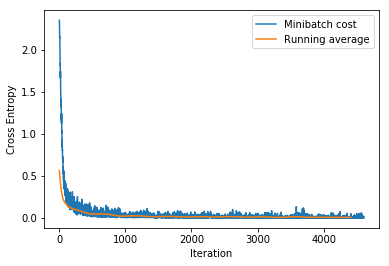

In [14]:
plt.plot(cost_list, label='Minibatch cost')
plt.plot(np.convolve(cost_list, 
                     np.ones(200,)/200, mode='valid'), 
         label='Running average')

plt.ylabel('Cross Entropy')
plt.xlabel('Iteration')
plt.legend()

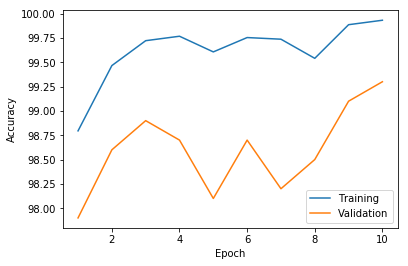

In [15]:
plt.plot(np.arange(1, NUM_EPOCHS+1), train_acc_list, label='Training')
plt.plot(np.arange(1, NUM_EPOCHS+1), valid_acc_list, label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [16]:
with torch.set_grad_enabled(False):
    test_acc = compute_acc(model=model,
                           data_loader=test_loader,
                           device=DEVICE)
    
    valid_acc = compute_acc(model=model,
                            data_loader=valid_loader,
                            device=DEVICE)
    

print(f'Validation ACC: {valid_acc:.2f}%')
print(f'Test ACC: {test_acc:.2f}%')

Validation ACC: 99.30%
Test ACC: 98.94%
